In [1]:
import numpy as np
import pandas as pd
import emcee
import corner
from scipy.optimize import minimize
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
sn = 'ZTF18aaxsioa'
lc_df = pd.read_hdf("../../forced_lightcurves/mcmc_nob_ref_base/{}_force_phot.h5".format(sn))
salt_df = pd.read_csv("../../MB_SALT_020419.csv")

In [4]:
lc_df.columns

Index(['jdobs', 'filter', 'seeing', 'gain', 'zp', 'ezp', 'programid',
       'fieldid', 'ccdid', 'qid', 'filterid', 'moonra', 'moondec', 'moonillf',
       'moonphase', 'airmass', 'nbad', 'nbadbkg', 'bkgstd', 'bkgmed',
       'diffimgname', 'psfimgname', 'Fmcmc', 'Fmcmc_unc', 'Fratio',
       'Fratio_unc', 'jdref_start', 'jdref_end', 'fcqfid', 'scisigpix',
       'offset', 'multiply'],
      dtype='object')

In [5]:
lc_df.head()

,jdobs,filter,seeing,gain,zp,ezp,programid,fieldid,ccdid,qid,...,Fmcmc,Fmcmc_unc,Fratio,Fratio_unc,jdref_start,jdref_end,fcqfid,scisigpix,offset,multiply
0,2.458207e+06,b'g',1.866,6.285773,26.325,0.000007,2.0,762.0,3.0,1.0,...,-8.579024,37.693863,-2.531849e-10,1.112425e-09,2.458167e+06,2.458206e+06,7620311.0,11.21120,-1.966177,1.205303
1,2.458207e+06,b'g',1.754,6.337326,26.325,0.000006,2.0,762.0,3.0,1.0,...,33.257029,33.546718,9.814845e-10,9.900338e-10,2.458167e+06,2.458206e+06,7620311.0,10.79940,-1.966177,1.205303
2,2.458207e+06,b'g',1.932,6.407937,26.325,0.000006,2.0,762.0,3.0,1.0,...,-78.081065,30.324806,-2.304336e-09,8.949485e-10,2.458167e+06,2.458206e+06,7620311.0,10.22320,-1.966177,1.205303
3,2.458207e+06,b'g',1.488,6.357772,26.325,0.000006,2.0,762.0,3.0,1.0,...,-49.245352,27.678836,-1.453333e-09,8.168604e-10,2.458167e+06,2.458206e+06,7620311.0,9.83011,-1.966177,1.205303
4,2.458207e+06,b'g',1.571,6.322593,26.325,0.000005,2.0,762.0,3.0,1.0,...,-9.601294,26.382000,-2.833543e-10,7.785880e-10,2.458167e+06,2.458206e+06,7620311.0,8.77830,-1.966177,1.205303


<IPython.core.display.Javascript object>


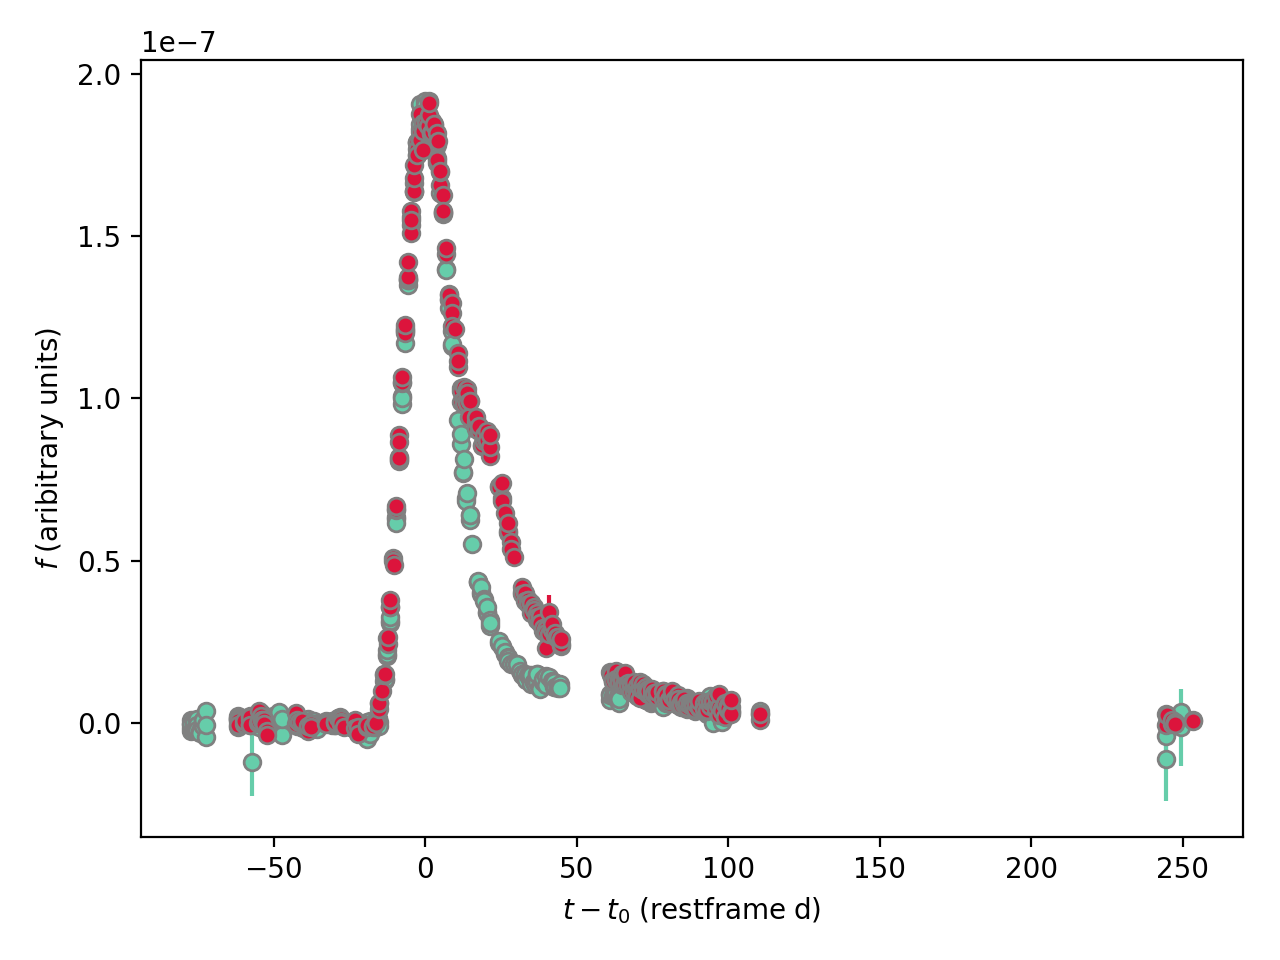

In [6]:
g_obs = np.where((lc_df['programid'] == 2.0) & 
                 (lc_df['offset'] > -999) & 
                 (lc_df['filter'] == b'g'))
r_obs = np.where((lc_df['programid'] == 2.0) & 
                 (lc_df['offset'] > -999) & 
                 (lc_df['filter'] == b'r'))
obs = np.where( (lc_df['programid'] == 2.0) & 
                (lc_df['offset'] > -999)  
              )

t0 = float(salt_df['t0'][salt_df['sn'] == sn].values) + 2400000.5
z = float(salt_df['z'][salt_df['sn'] == sn].values)

fig, ax = plt.subplots()
ax.errorbar((lc_df['jdobs'].iloc[g_obs] - t0)/(1+z), 
            lc_df['Fratio'].iloc[g_obs],
            lc_df['Fratio_unc'].iloc[g_obs], 
            fmt = 'o', color='MediumAquaMarine',
            mec='0.5')
ax.errorbar((lc_df['jdobs'].iloc[r_obs] - t0)/(1+z), 
            lc_df['Fratio'].iloc[r_obs],
            lc_df['Fratio_unc'].iloc[r_obs], 
            fmt = 'o', color='Crimson',
            mec='0.5')
ax.set_xlabel('$t - t_0 \; (\mathrm{restframe \; d})$')
ax.set_ylabel('$f \; (\mathrm{aribitrary \; units})$')
fig.tight_layout()

In [14]:
def f_t(times, amplitude=25, t_0=0, alpha_r=2):
    
    return amplitude * (times - t_0)**alpha_r

In [64]:
def plot_model(t, f, f_unc, theta):
    half_max = np.where((f < 0.5) & (t < 0))
    
    t_post = np.linspace(theta[0], 80, 1000)
    t_pre = np.linspace(min(t), theta[0], 1000)
    model_flux = theta[1] + f_t(t_post, theta[2], theta[0], theta[3])
    fig = plt.figure()
    axPlot = plt.axes([0.15, 0.37, 0.85, 0.61])
    axRes = plt.axes([0.15, 0.1, 0.85, 0.25])
    axPlot.errorbar(t, f, f_unc,
                fmt = 'o', color='MediumAquaMarine',
                mec='0.5')
    axPlot.plot(t_post, model_flux, 'k', zorder=10)
    axPlot.plot(t_pre, np.ones_like(t_pre)*theta[1], 'k', zorder=10)
    axPlot.plot([max(t[half_max]),max(t[half_max])], [-50,50], 
               '--', color='DarkOrange')
    axPlot.set_xlim(min(t), 3)
    axPlot.set_ylim(min(f), 1.1)

    after_exp = t >= theta[0]
    
    residuals = np.append(f[~after_exp] - theta[1], 
                          f[after_exp] - (theta[1] + f_t(t[after_exp], theta[2], theta[0], theta[3]))  
                         )
    
    axRes.errorbar(t, residuals, f_unc,
                   fmt = 'o', color='MediumAquaMarine',
                   mec='0.5')
    axRes.plot([-5000,10000], [0,0], 'k--')
    axRes.plot([max(t[half_max]),max(t[half_max])], [-50,50], 
               '--', color='DarkOrange')
    axRes.set_xlim(min(t), 3)


    axRes.set_ylim(min(residuals[half_max]), max(residuals[half_max]))
    axRes.set_xlabel('$t - t_0 \; (\mathrm{restframe \; d})$')
    axPlot.set_ylabel('$f \; (\mathrm{aribitrary \; units})$')
#     fig.tight_layout()
    
    return

In [98]:
def lnlike_simple(theta, f, t, f_err):
    t_0, a, a_prime, alpha_r = theta
    
    pre_exp = np.logical_not(t > t_0)
    model = np.empty_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)
    model[~pre_exp] = a + a_prime * (time_term)**alpha_r
    
    ln_l = -0.5*np.sum((f - model)**2 / (f_err**2))
    return ln_l

def nll_simple(theta, f, t, f_err):
    return -1*lnlike_simple(theta, f, t, f_err)

#Define priors on parameters  
def lnprior_simple(theta):
    t_0, a, a_prime, alpha_r = theta
    if (-1e8 < t_0 < 1e8 and 0 < alpha_r < 1e8 and 
        -1e8 < a < 1e8 and 
        0 < a_prime < 1e8):
        return 0.0
    return -np.inf

def lnposterior_simple(theta, f, t, f_err):
    lnp = lnprior_simple(theta)
    lnl = lnlike_simple(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp

In [130]:
time_jd = (lc_df['jdobs'].iloc[r_obs].values - t0)/(1+z)
max_flux = np.max(lc_df['Fratio'].iloc[r_obs].values)
# normalize flux as units are arbitrary and 
# we marginalize over the amplitude anyway
flux = lc_df['Fratio'].iloc[r_obs].values/max_flux
flux_unc = lc_df['Fratio_unc'].iloc[r_obs].values/max_flux
t_fl = 16.5

guess_0 = [-t_fl, 0, 6e-3, 2]

half_max = np.where((flux < 0.25) & (time_jd < 0))
f_data = flux[half_max]
t_data = time_jd[half_max]
f_unc_data = flux_unc[half_max]

In [131]:
# initialize near maximum-likelihood result
ml_res = minimize(nll_simple, guess_0, method='Powell', # Powell method does not need derivatives
                  args=(f_data, t_data, f_unc_data))
ml_guess = ml_res.x
print(ml_guess)
print(nll_simple(ml_guess, f_data, t_data, f_unc_data))

[-1.71722791e+01  2.44146567e-03  5.88992165e-03  2.00015434e+00]
79.65534095209566


<IPython.core.display.Javascript object>


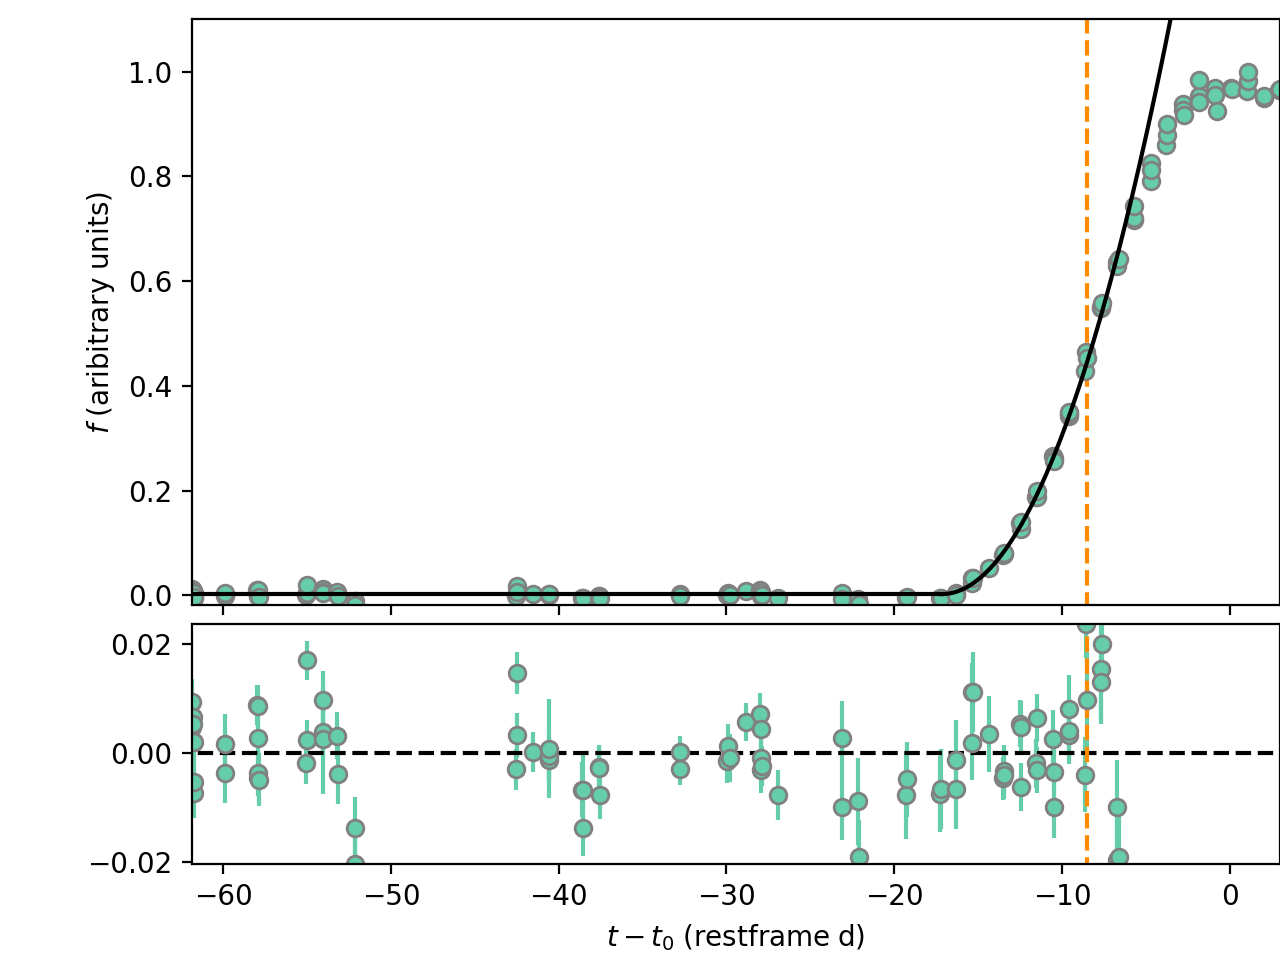

In [132]:
plot_model(time_jd, flux, flux_unc,
           ml_guess)

In [ ]:
###################################
###  sample without sig_0 term  ###
###################################


nwalkers = 250
ndim = len(ml_guess)
nfac = [1e-2]*ndim

#initial position of walkers
pos = [ml_guess + ml_guess * nfac * np.random.randn(ndim) for i in range(nwalkers)]
# pos = [[-16.7, 0, 0.01, 2] + nfac * np.random.randn(ndim) for i in range(nwalkers)]

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior_simple, 
                                    args=(f_data, t_data, f_unc_data),
                                    pool=pool)
    max_samples = 50000
    index = 0
    autocorr = np.empty(max_samples)
    old_tau = np.inf
    check_tau = 2500
    for sample in sampler.sample(pos, iterations=max_samples, progress=True):
        if sampler.iteration % check_tau:
            continue
        
        tstart = time.time()
        tau = sampler.get_autocorr_time(tol=0)
        tend = time.time()
        autocorr[index] = np.mean(tau)
        index += 1
        steps_so_far = index*check_tau
        print('''After {:d} steps, 
autocorrelation takes {:.3f} s ({} total FFTs)                
acceptance fraction = {:.4f}, and
tau = {}'''.format(steps_so_far, 
                   tend-tstart, nwalkers*ndim,
                   np.mean(sampler.acceptance_fraction), 
                   tau))

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

  5%|▌         | 2521/50000 [00:18<08:32, 92.62it/s] 

After 2500 steps, 
autocorrelation takes 0.198 s (1000 total FFTs)                
acceptance fraction = 0.3284, and
tau = [208.80586443  84.62174679 212.1715407  213.20906572]


 10%|█         | 5015/50000 [00:36<11:28, 65.30it/s] 

After 5000 steps, 
autocorrelation takes 0.409 s (1000 total FFTs)                
acceptance fraction = 0.2932, and
tau = [380.51341614 114.45337515 378.72164694 389.86770381]


 11%|█▏        | 5665/50000 [12:01:41<13970:39:22, 1134.42s/it]

<IPython.core.display.Javascript object>


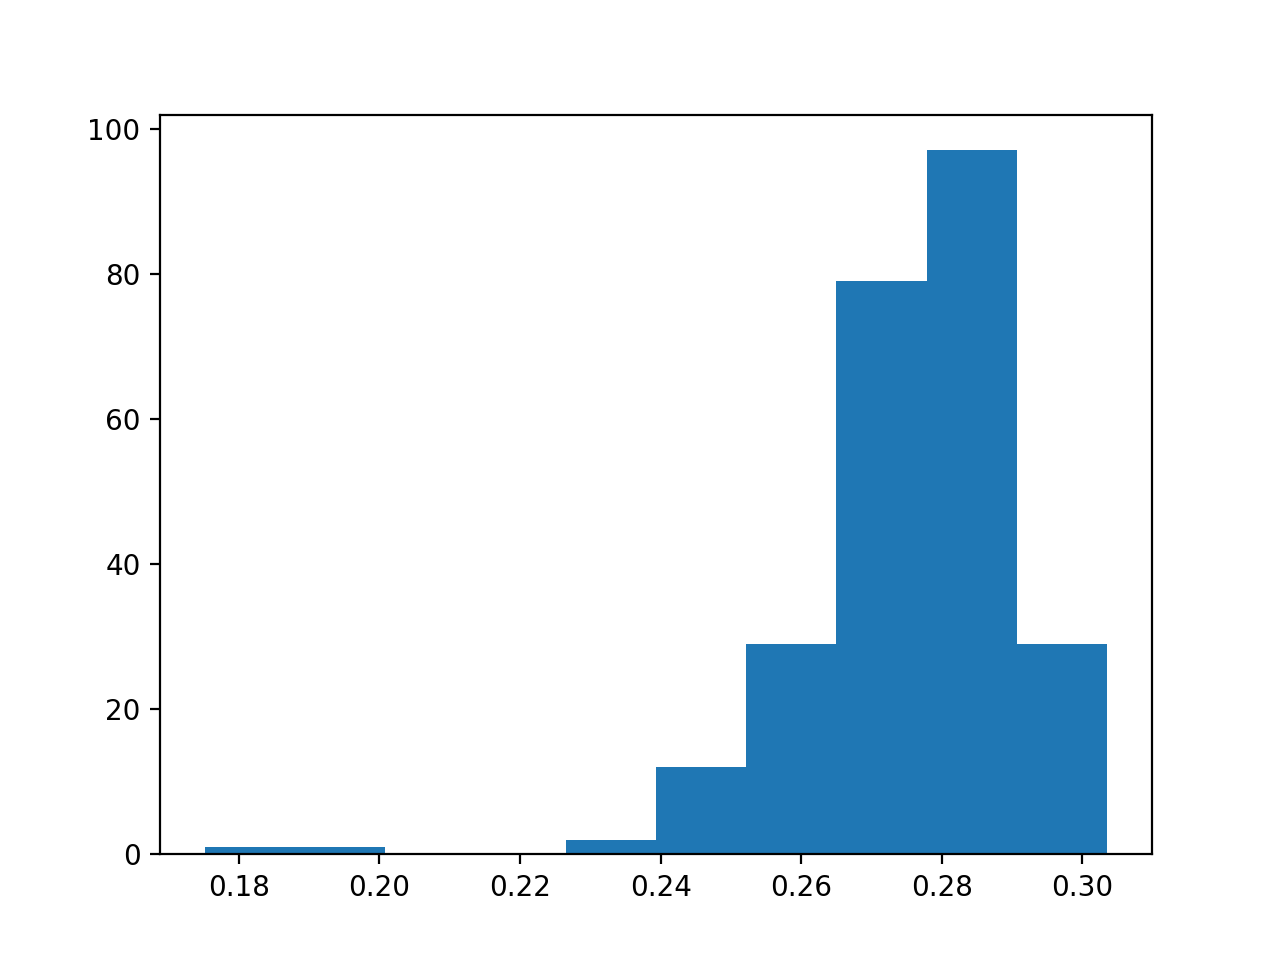

(array([ 1.,  1.,  0.,  0.,  2., 12., 29., 79., 97., 29.]),
 array([0.1752  , 0.188028, 0.200856, 0.213684, 0.226512, 0.23934 ,
        0.252168, 0.264996, 0.277824, 0.290652, 0.30348 ]),
 <a list of 10 Patch objects>)

In [127]:
plt.figure()
plt.hist(sampler.acceptance_fraction)

<IPython.core.display.Javascript object>


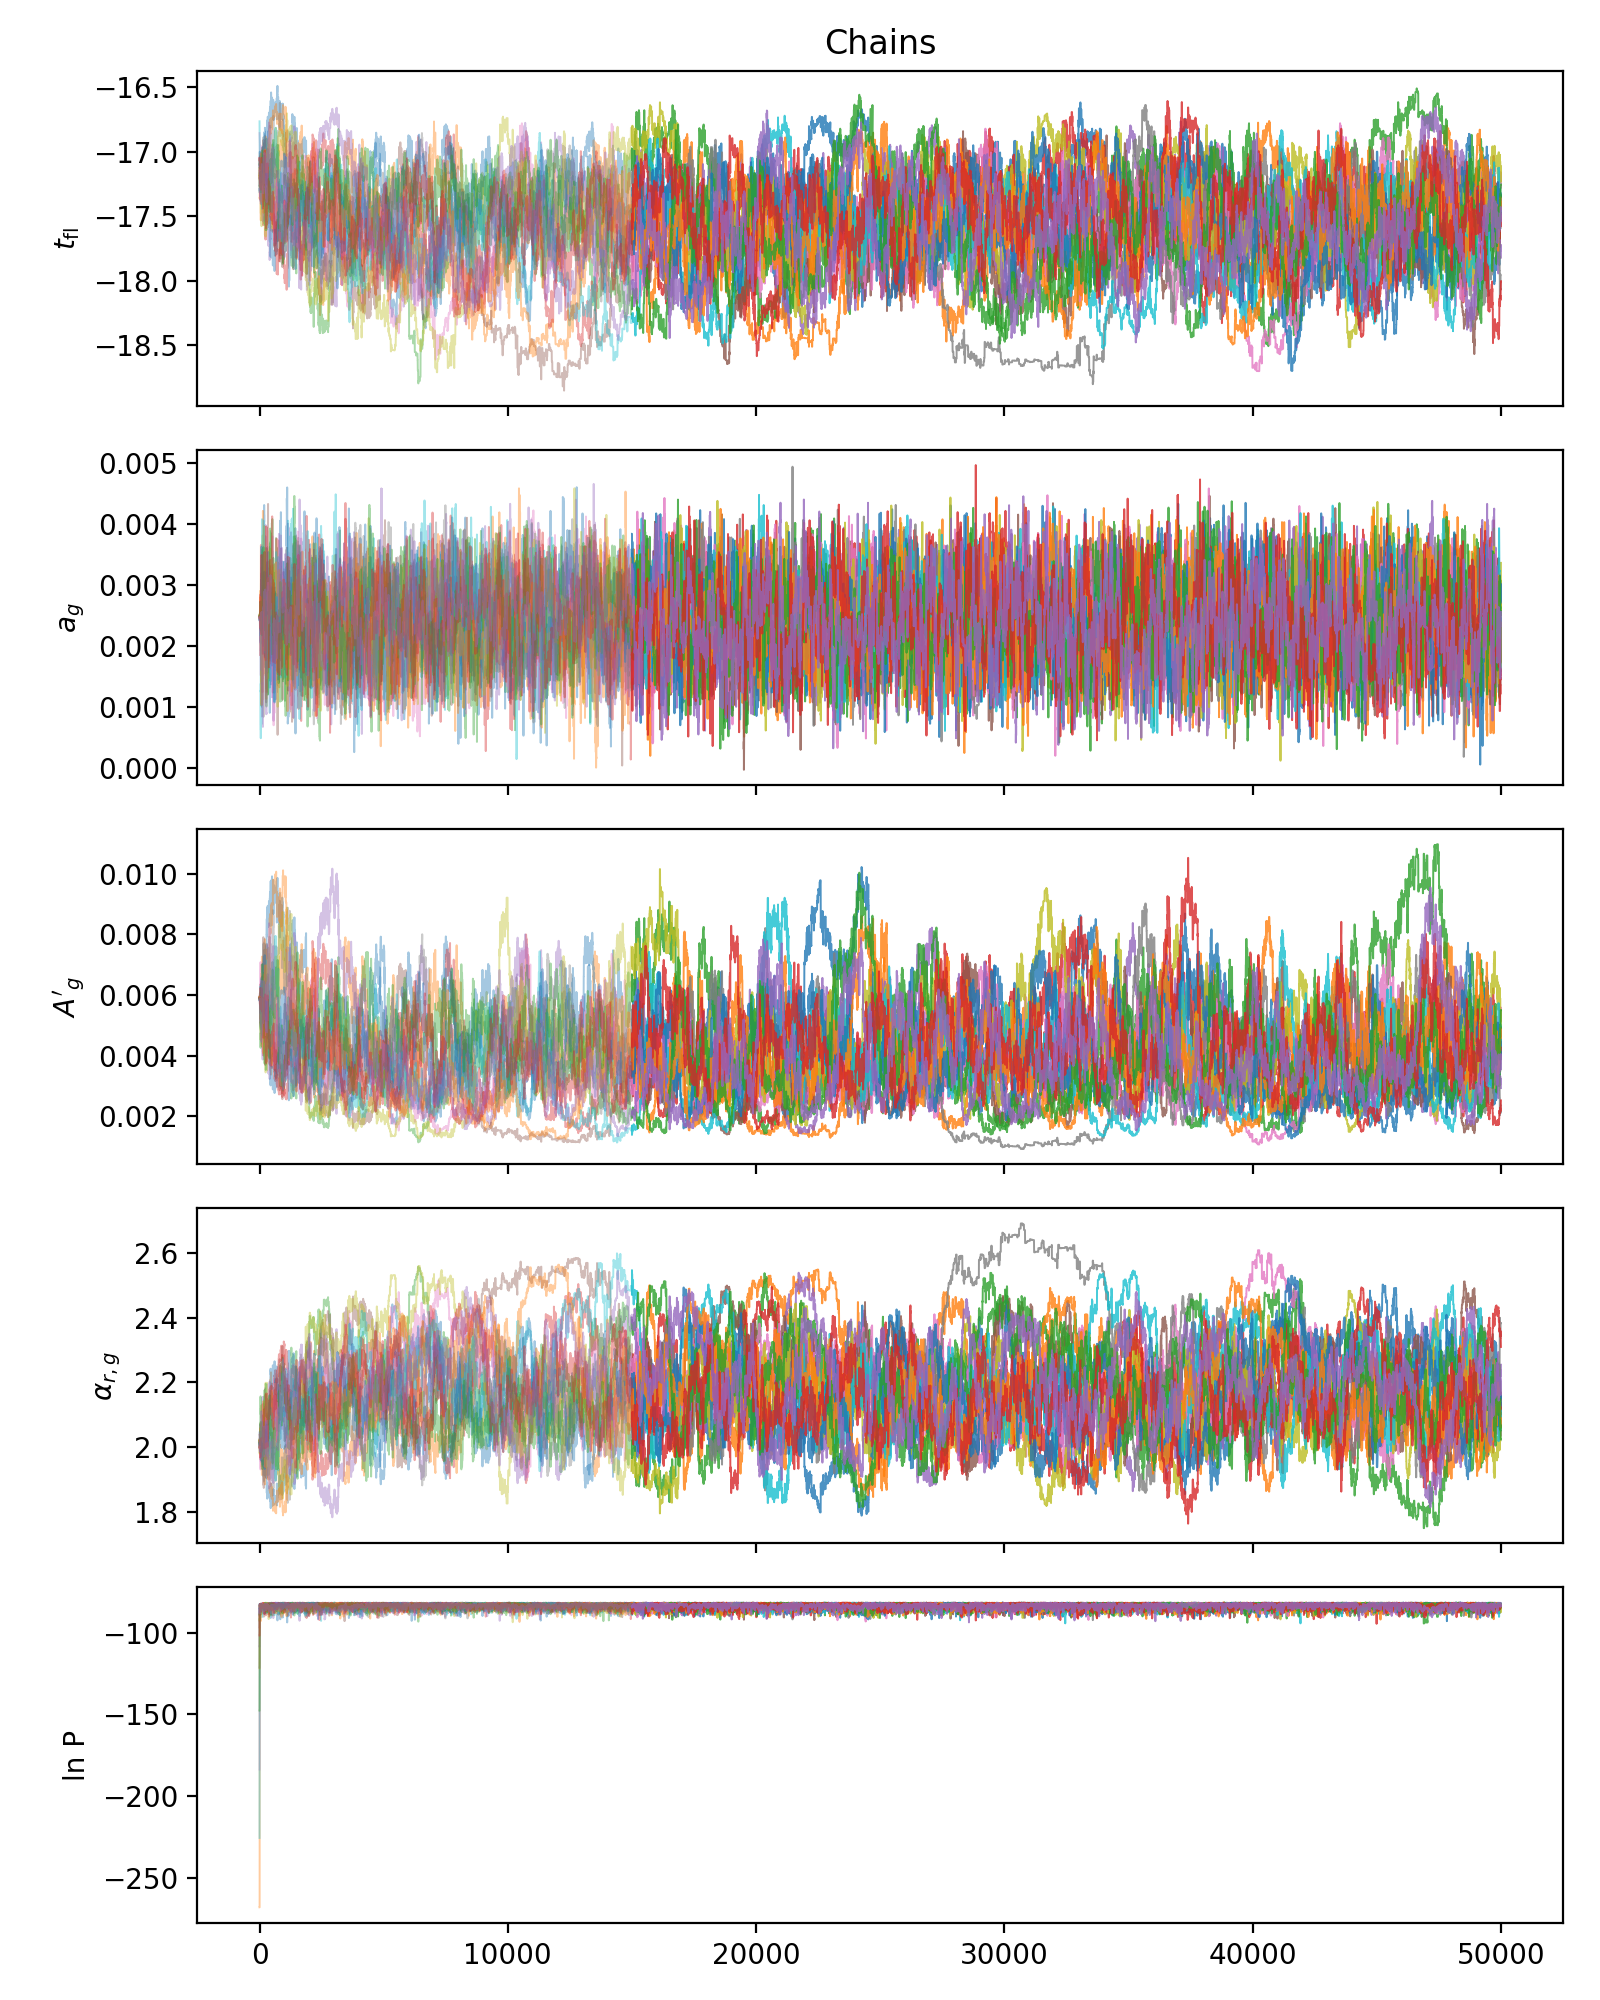

In [128]:
plotChains(sampler, 15000, paramsNames, nplot=15)
plt.tight_layout()

<IPython.core.display.Javascript object>


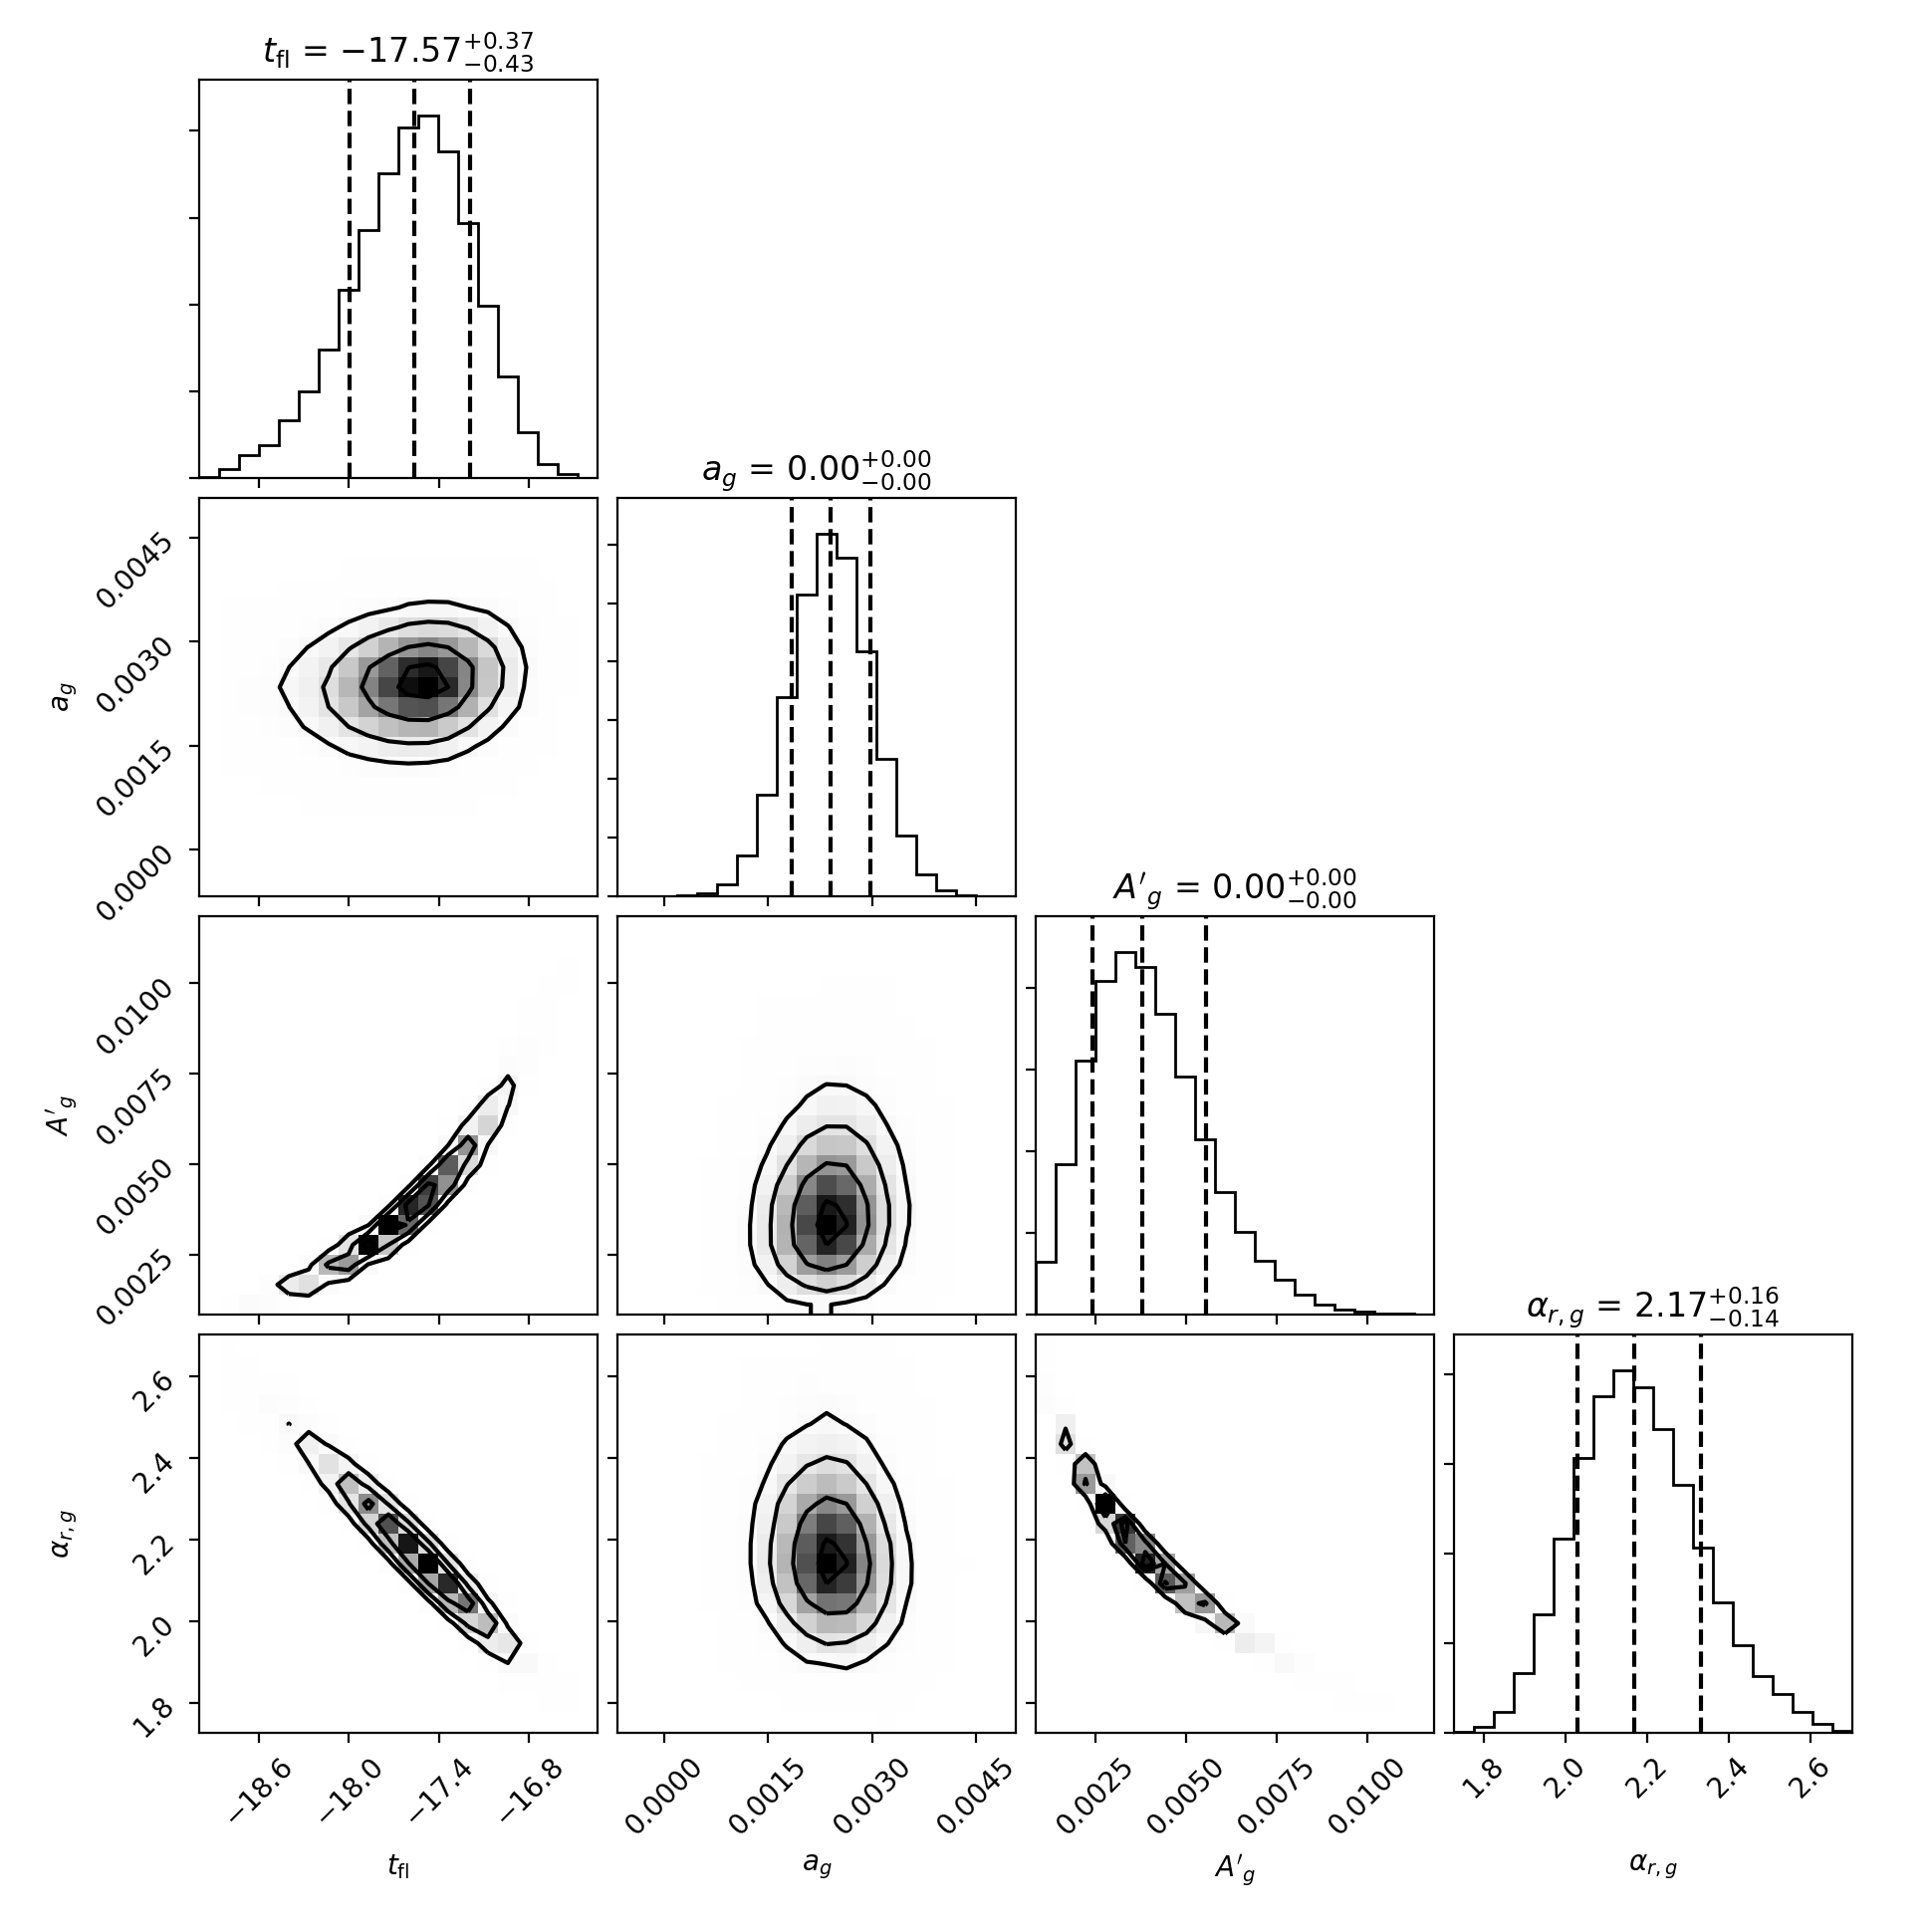

In [129]:
makeCorner(sampler, 25000, paramsNames)

In [65]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84], truths=[]):
    samples = sampler.get_chain(discard=nburn, flat=True)
    if len(truths) > 0:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          truths=truths, plot_datapoints=False)
    else:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          show_titles=True, plot_datapoints=False)
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=nwalkers):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    selected_walkers = np.random.choice(range(sampler.get_chain().shape[1]), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.get_chain()[:nburn,w,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.get_chain(discard=nburn)[:,w,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.get_log_prob()[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.get_log_prob(discard=nburn)[:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax

paramsNames=[r'$t_\mathrm{fl}$', 
             '$a_g$', r"$A'_g$", r'$\alpha_{r, g}$']
gr_paramsNames=[r'$t_\mathrm{fl}$', 
             '$a_g$', r"$A'_g$", '$t_{b,g}$', r'$\alpha_{r, g}$', r'$\alpha_{d, g}$', '$s_g$',
             '$a_r$', r"$A'_r$", '$t_{b,r}$', r'$\alpha_{r, r}$', r'$\alpha_{d, r}$', '$s_r$']
